In [28]:
import pandas as pd
import numpy as np
from pathlib import Path

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# encoding / scaling
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

In [29]:
csv_path = Path("pune_clean.csv")
if not csv_path.exists():
    raise FileNotFoundError(f"{csv_path} not found. Put your CSV in the working folder as 'pune_clean.csv'.")

df = pd.read_csv(csv_path, dtype=object)   # read as object to avoid dtype surprises
df_orig = df.copy()    

In [30]:
df.columns = [c.replace(".", "_").strip() for c in df.columns]

# quick peek
print("shape:", df.shape)
display(df.head())

shape: (2668, 263)


,name,lat,lon,category,price_tier,popularity,photo_url,tags_name,tags_tourism,tags_brand,...,tags_postal_code,tags_charge,tags_waterway,tags_location,tags_lit,tags_highway,tags_diet:omnivore,tags_addr:neighborhood,tags_building:levels:underground,tags_type
0,Lion Point,18.7041145,73.3876167,viewpoint,2,0.6000000000000001,NaN,Lion Point,viewpoint,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Reliance Fresh,18.5480228,73.920474,supermarket,2,0.4,NaN,Reliance Fresh,NaN,Reliance Fresh,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,McDonald's,18.5457237,73.9062599,fast_food,2,0.4,NaN,McDonald's,NaN,McDonald's,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,The Charcoal Pit,18.5167868,73.8791405,restaurant,2,0.5,NaN,The Charcoal Pit,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,The Great Punjab,18.5364098,73.8973015,restaurant,2,0.5,NaN,The Great Punjab,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df.columns

Index(['name', 'lat', 'lon', 'category', 'price_tier', 'popularity',
       'photo_url', 'tags_name', 'tags_tourism', 'tags_brand',
       ...
       'tags_postal_code', 'tags_charge', 'tags_waterway', 'tags_location',
       'tags_lit', 'tags_highway', 'tags_diet:omnivore',
       'tags_addr:neighborhood', 'tags_building:levels:underground',
       'tags_type'],
      dtype='object', length=263)

In [32]:
df = df.dropna(axis=1, how="all")


In [33]:
def to_numeric(col):
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

for col in ["lat", "lon", "popularity", "price_tier"]:
    to_numeric(col)

In [34]:
for col in ["name", "category"]:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")

In [35]:
if "popularity" in df.columns:
    df["popularity"] = df["popularity"].fillna(df["popularity"].mean())

if "price_tier" in df.columns:
    # round mode to int if appropriate
    try:
        mode_val = int(df["price_tier"].mode().iloc[0])
    except Exception:
        mode_val = 2
    df["price_tier"] = df["price_tier"].fillna(mode_val).astype(int)

In [36]:
possible_tag_cols = [c for c in df.columns if c.startswith("tags_") or c.startswith("tags")]
# make them shorter e.g. tags_name -> tag_name
df.rename(columns={c: c.replace("tags_", "tag_") for c in possible_tag_cols}, inplace=True)

# create simple 'amenity' and 'cuisine' canonical columns if available
if "tag_amenity" in df.columns:
    df["amenity"] = df["tag_amenity"].fillna("Unknown")
elif "tag_name" in df.columns:
    # fallback
    df["amenity"] = df["tag_name"].fillna("Unknown")

if "tag_cuisine" in df.columns:
    df["cuisine"] = df["tag_cuisine"].fillna("Unknown")
else:
    df["cuisine"] = df.get("cuisine", pd.Series(["Unknown"] * len(df))).fillna("Unknown")

In [37]:
# ----------------------------
df["short_name"] = df["name"].astype(str).str.replace(r"[^0-9A-Za-z\s\-&']", "", regex=True).str.strip().str.slice(0,60)
df["name_length"] = df["name"].astype(str).apply(len)
df["popular_flag"] = (df["popularity"] >= df["popularity"].median()).astype(int)


In [38]:
le_cat = LabelEncoder()
df["category_filled"] = df["category"].fillna("Unknown")
df["category_enc"] = le_cat.fit_transform(df["category_filled"])

In [39]:
topk = 12
amenity_counts = df["amenity"].value_counts(dropna=True)
top_amenities = amenity_counts.head(topk).index.tolist()
df["amenity_topk"] = df["amenity"].where(df["amenity"].isin(top_amenities), other="OTHER")

# one-hot (small set)
df = pd.concat([df, pd.get_dummies(df["amenity_topk"], prefix="amen")], axis=1)

# ----------------------------
# 8) Save processed CSV
# ----------------------------
processed_path = "pune_processed.csv"
df.to_csv(processed_path, index=False, encoding="utf-8")
print("Saved processed CSV ->", processed_path)

Saved processed CSV -> pune_processed.csv



--- Basic stats ---


,lat,lon,popularity,price_tier
count,2668.000000,2668.000000,2668.000000,2668.000000
mean,18.561761,73.814723,0.460307,2.009370
std,0.106322,0.116138,0.061498,0.169657
min,18.056148,73.360895,0.400000,1.000000
25%,18.509653,73.770847,0.400000,2.000000
50%,18.550835,73.812636,0.500000,2.000000
75%,18.596470,73.863877,0.500000,2.000000
max,19.372462,75.025483,0.900000,4.000000


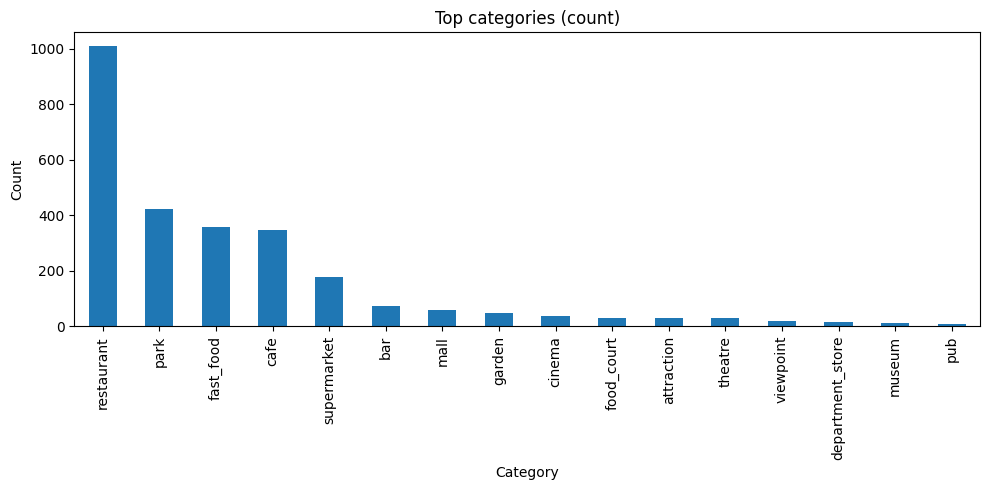

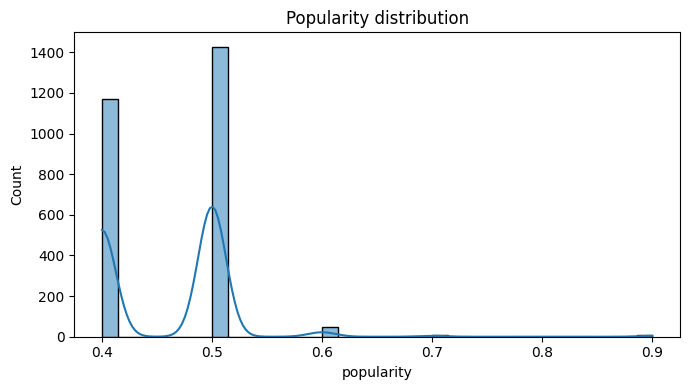

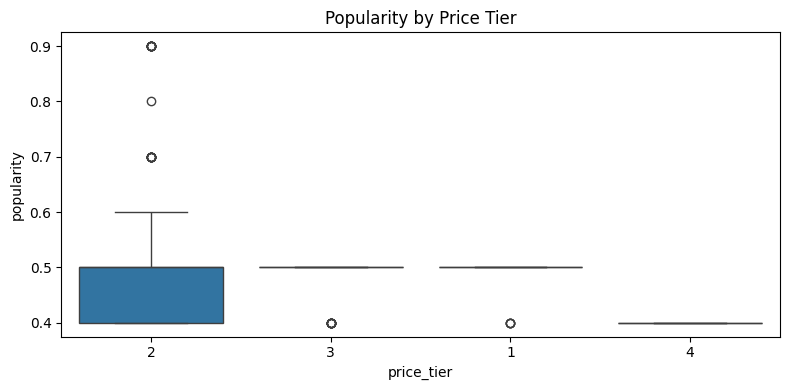

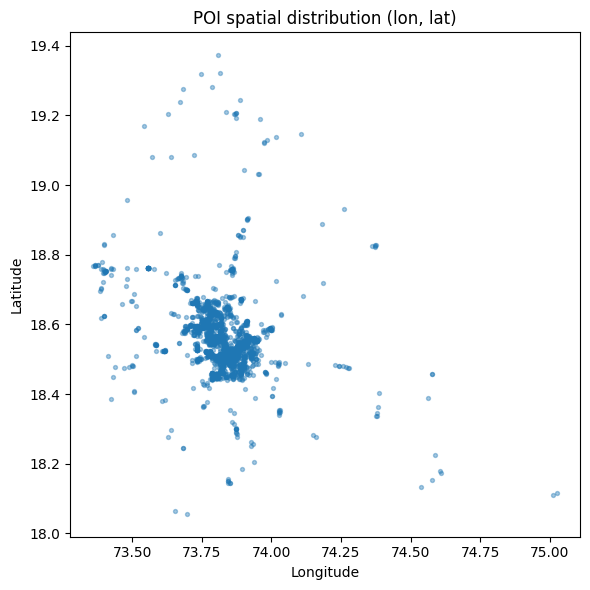

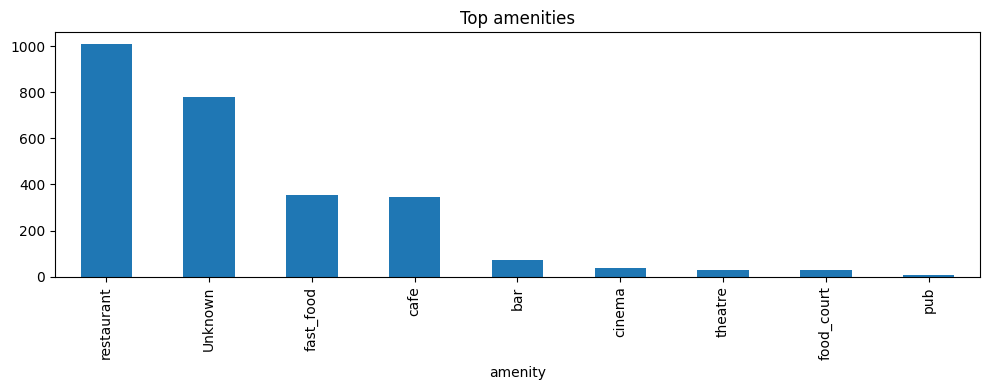

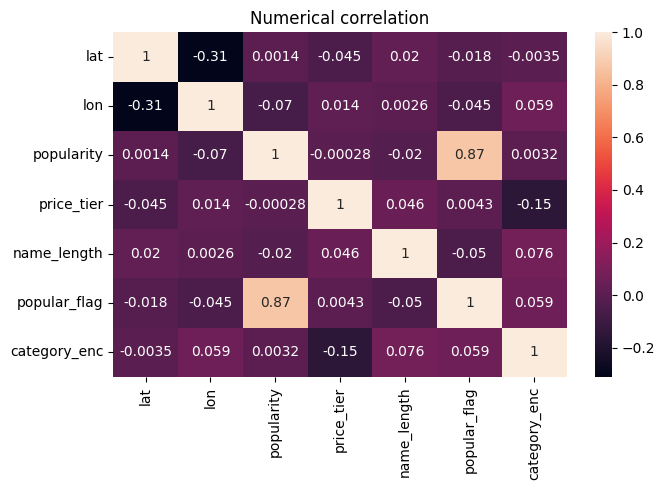

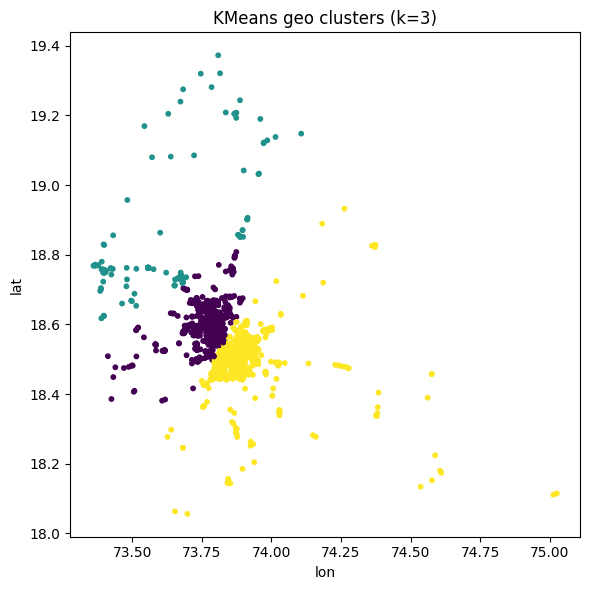


Done. Processed saved to: pune_processed.csv
Columns now include a few engineered features such as: short_name, name_length, popular_flag, category_enc, amen_* dummies, geo_cluster (optional).


In [41]:


# ----------------------------
# 9) Exploratory Data Analysis (plots + quick stats)
# ----------------------------
# Basic stats
print("\n--- Basic stats ---")
display(df[["lat","lon","popularity","price_tier"]].describe())

# Category counts
plt.figure(figsize=(10,5))
vc = df["category"].value_counts().head(25)
vc.plot(kind="bar")
plt.title("Top categories (count)")
plt.xlabel("Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Popularity distribution
plt.figure(figsize=(7,4))
sns.histplot(df["popularity"].dropna(), kde=True)
plt.title("Popularity distribution")
plt.xlabel("popularity")
plt.tight_layout()
plt.show()

# Price tier vs popularity (boxplot)
if "price_tier" in df.columns and "popularity" in df.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df["price_tier"].astype(str), y=df["popularity"])
    plt.title("Popularity by Price Tier")
    plt.xlabel("price_tier")
    plt.tight_layout()
    plt.show()

# Scatter: lat/lon (spatial)
plt.figure(figsize=(6,6))
plt.scatter(df["lon"].astype(float), df["lat"].astype(float), alpha=0.4, s=8)
plt.title("POI spatial distribution (lon, lat)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

# Top amenities
plt.figure(figsize=(10,4))
df["amenity"].value_counts().head(20).plot(kind="bar")
plt.title("Top amenities")
plt.tight_layout()
plt.show()

# Correlation heatmap (numerical only)
num_cols = ["lat","lon","popularity","price_tier","name_length","popular_flag","category_enc"]
num_cols = [c for c in num_cols if c in df.columns]
if len(num_cols) >= 2:
    plt.figure(figsize=(7,5))
    sns.heatmap(df[num_cols].corr(), annot=True)
    plt.title("Numerical correlation")
    plt.tight_layout()
    plt.show()

# ----------------------------
# 10) Optional: Clustering example (KMeans on lat/lon)
# ----------------------------
coords = df[["lat","lon"]].dropna().astype(float)
if len(coords) >= 10:
    # pick k using elbow-ish quick method
    k = 3
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(coords)
    df.loc[coords.index, "geo_cluster"] = km.labels_.astype(int)
    plt.figure(figsize=(6,6))
    plt.scatter(coords["lon"], coords["lat"], c=km.labels_, s=10)
    plt.title(f"KMeans geo clusters (k={k})")
    plt.xlabel("lon")
    plt.ylabel("lat")
    plt.tight_layout()
    plt.show()

# ----------------------------
# End: brief summary
# ----------------------------
print("\nDone. Processed saved to:", processed_path)
print("Columns now include a few engineered features such as: short_name, name_length, popular_flag, category_enc, amen_* dummies, geo_cluster (optional).")
